In [ ]:
# You only need to run this once per machine
!pip install -q -U bitsandbytes transformers peft accelerate datasets scipy matplotlib einops torch huggingface_hub

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [2]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset
import matplotlib.pyplot as plt
import transformers
from datetime import datetime

fsdp_plugin = FullyShardedDataParallelPlugin(state_dict_config = FullStateDictConfig(offload_to_cpu = True, rank0_only = False),
                                             optim_state_dict_config = FullOptimStateDictConfig(offload_to_cpu = True, rank0_only = False),
                                             )

accelerator = Accelerator(fsdp_plugin = fsdp_plugin)

dataset_name = 'summ_examples_phi.jsonl'
dataset = load_dataset("json", data_files = dataset_name, split = 'train')
dataset = dataset.train_test_split(test_size = 0.08)

base_model_id = "microsoft/phi-2"
model = AutoModelForCausalLM.from_pretrained(base_model_id, trust_remote_code=True, torch_dtype=torch.float16, load_in_8bit=True)

tokenizer = AutoTokenizer.from_pretrained(base_model_id,
                                          padding_side = "left",
                                          add_eos_token = True,
                                          add_bos_token = True,
                                          use_fast = False, # needed for now, should be fixed soon
                                          )
                                        
tokenizer.pad_token = tokenizer.eos_token

def formatting_func(example):
    text = f"example['input']\n ### Answer: {example['output']}"
    return text

def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))

tokenized_train_dataset = dataset['train'].map(generate_and_tokenize_prompt)
tokenized_val_dataset = dataset['test'].map(generate_and_tokenize_prompt)

Detected kernel version 4.14.334, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Map:   0%|          | 0/1092 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (5218 > 2048). Running this sequence through the model will result in indexing errors


Map:   0%|          | 0/96 [00:00<?, ? examples/s]

1188


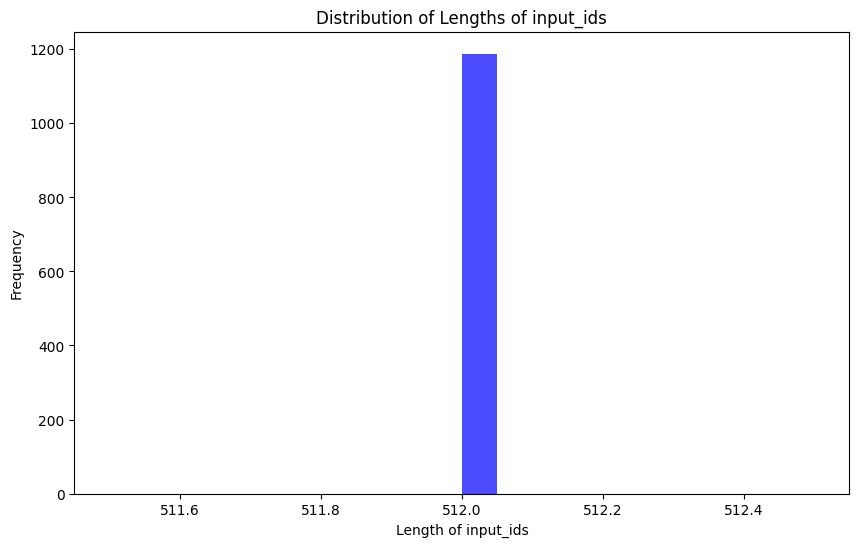

In [6]:
def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [3]:
max_length = 512 # This was an appropriate max length for my dataset

def generate_and_tokenize_prompt2(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

tokenized_train_dataset = dataset['train'].map(generate_and_tokenize_prompt2)
tokenized_val_dataset = dataset['test'].map(generate_and_tokenize_prompt2)

Map:   0%|          | 0/1092 [00:00<?, ? examples/s]

Map:   0%|          | 0/96 [00:00<?, ? examples/s]

In [4]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "Wqkv",
        "fc1",
        "fc2",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)

model = accelerator.prepare_model(model)
if torch.cuda.device_count() > 1: # If more than 1 GPU
    model.is_parallelizable = True
    model.model_parallel = True

In [5]:
project = "dolly-sum-finetune"
base_model_name = "phi2"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=1,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=1,
        max_steps=500,
        learning_rate=2.5e-5, # Want a small lr for finetuning
        optim="paged_adamw_8bit",
        logging_steps=25,              # When to start reporting loss
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=25,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=25,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()
trainer.push_to_hub()

Detected kernel version 4.14.334, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss,Validation Loss
25,2.932900,2.417841
50,2.483200,2.154131
75,2.168800,2.077417
100,2.224700,2.072451
125,2.225000,2.065174
150,2.221700,2.063517
175,2.228200,2.061139
200,2.110400,2.060776
225,2.158300,2.056880
250,2.119700,2.056549


adapter_model.safetensors:   0%|          | 0.00/105M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.66k [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/alk/phi2-dolly-sum-finetune/commit/514fb825329b6613ed4d18e1c910a03961564eb6', commit_message='End of training', commit_description='', oid='514fb825329b6613ed4d18e1c910a03961564eb6', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
from peft import PeftModel, PeftConfig
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
from tqdm.notebook import tqdm
import pandas as pd

device = "cuda"

base_model_id = "microsoft/phi-2"
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  # Phi2, same as before
    device_map="auto",
    trust_remote_code=True,
    load_in_8bit=True,
    torch_dtype=torch.float16,
)

ft_model = PeftModel.from_pretrained(base_model, "alk/phi2-dolly-sum-finetune")

tokenizer = AutoTokenizer.from_pretrained(base_model_id, 
                                          add_bos_token = True, 
                                          trust_remote_code = True, 
                                          use_fast = False, 
                                          device = device
                                         )
tokenizer.pad_token = tokenizer.eos_token

def get_summary(input_str: str) -> str:

    eval_prompt = f"""Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Summarize the following text.
Input:

{input_str}
### Response:
"""
    model_input = tokenizer(eval_prompt, return_tensors="pt").to(device)

    ft_model.eval()
    with torch.no_grad():
        output = tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=300, repetition_penalty=1.11)[0], skip_special_tokens=True)
    return output

# sample input prompt
"""Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Summarize the following text.
Input:

"I'd just like to interject for a moment. What you're refering to as Linux, is in fact, GNU/Linux, or as I've recently taken to calling it, GNU plus Linux. Linux is not an operating system unto itself, but rather another free component of a fully functioning GNU system made useful by the GNU corelibs, shell utilities and vital system components comprising a full OS as defined by POSIX.

Many computer users run a modified version of the GNU system every day, without realizing it. Through a peculiar turn of events, the version of GNU which is widely used today is often called Linux, and many of its users are not aware that it is basically the GNU system, developed by the GNU Project.

There really is a Linux, and these people are using it, but it is just a part of the system they use. Linux is the kernel: the program in the system that allocates the machine's resources to the other programs that you run. The kernel is an essential part of an operating system, but useless by itself; it can only function in the context of a complete operating system. Linux is normally used in combination with the GNU operating system: the whole system is basically GNU with Linux added, or GNU/Linux. All the so-called Linux distributions are really distributions of GNU/Linux!"
### Response:
"""

In [ ]:
df = pd.read_csv("sample_text_data.csv")
df_items = df.to_dict(orient="records")

output = []
for item in tqdm(df_items):
    output_row = {}
    for k, v in tqdm(item.items()):
        output_row[k] = v
        output_row[f"{k}_output"] = get_summary(v)
    output.append(output_row)
output_df = pd.DataFrame(output)
output_df.to_csv('phi2_finetune1_output.csv', index=False)
output_df